In [1110]:
# Basic
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# ML tools
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [1111]:
# Load dataset
data_path = "../data/processed/XY_bal_log_Rel/astro/XY_bal_log_Rel_astro.txt"
df_astro = pd.read_csv(data_path, sep='\s+')

# Preview the data
df_astro.head()

,E_peak,beta,sigma,beta_Rel,"0,1=astro,DM"
0,-0.412502,-1.325139,1.356951,-0.122193,0.0
1,0.708140,-0.000174,0.623167,-1.601886,0.0
2,0.224740,-0.581202,1.010041,-0.311249,0.0
3,0.257319,-0.561933,0.615413,-0.038913,0.0
4,0.326110,-1.100179,1.624932,-0.528753,0.0


In [1112]:
# Rename the weird column header for clarity
df_astro = df_astro.rename(columns={"0,1=astro,DM": "class"})

# Preview the structure
print(df_astro.columns)

Index(['E_peak', 'beta', 'sigma', 'beta_Rel', 'class'], dtype='object')


In [1113]:
df_astro.describe()

,E_peak,beta,sigma,beta_Rel,class
count,2831.000000,2831.000000,2831.000000,2831.000000,2831.0
mean,-0.086668,-0.935025,1.112434,-0.219436,0.0
std,1.280269,0.425847,0.370543,0.447146,0.0
min,-5.912006,-2.602060,0.609189,-3.198657,0.0
25%,-0.683526,-1.190440,0.819636,-0.431508,0.0
50%,0.008004,-0.935917,1.037837,-0.185014,0.0
75%,0.689384,-0.643496,1.328710,0.026877,0.0
max,5.918502,0.000000,2.899104,1.629309,0.0


## Visualization of Data

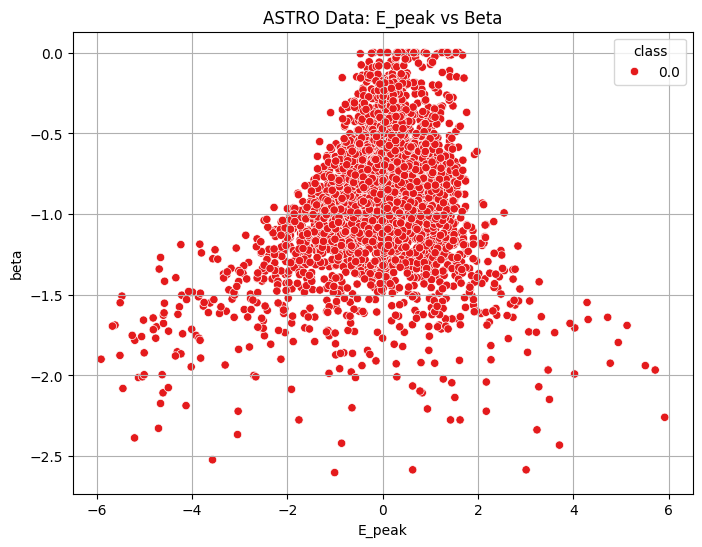

In [1114]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_astro, x="E_peak", y="beta", hue="class", palette="Set1")
plt.title("ASTRO Data: E_peak vs Beta")
plt.grid(True)
plt.show()

# Split data into Training and Testing (Within ASTRO) - Check distribution of both sets

In [1115]:
from sklearn.model_selection import train_test_split

X = df_astro[["beta", "E_peak"]].values
y = df_astro["class"].values

X_train, X_test = train_test_split(X, test_size=0.3, random_state=42)

Check training and testing data:

In [1116]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

X_train shape: (1981, 2)
X_test shape: (850, 2)


In [1117]:
# Convert to DataFrame for better readability
pd.DataFrame(X_train, columns=["E_peak", "beta"]).head()

,E_peak,beta
0,-0.630042,-0.346807
1,-0.894831,-0.480750
2,-0.321118,-0.029960
3,-0.473919,-0.444156
4,-0.849244,-0.411235


In [1118]:
pd.DataFrame(X_test, columns=["E_peak", "beta"]).head()

,E_peak,beta
0,-0.656198,0.836172
1,-0.960586,0.292411
2,-0.841035,-1.483399
3,-0.716925,-0.747560
4,-1.128427,0.383869


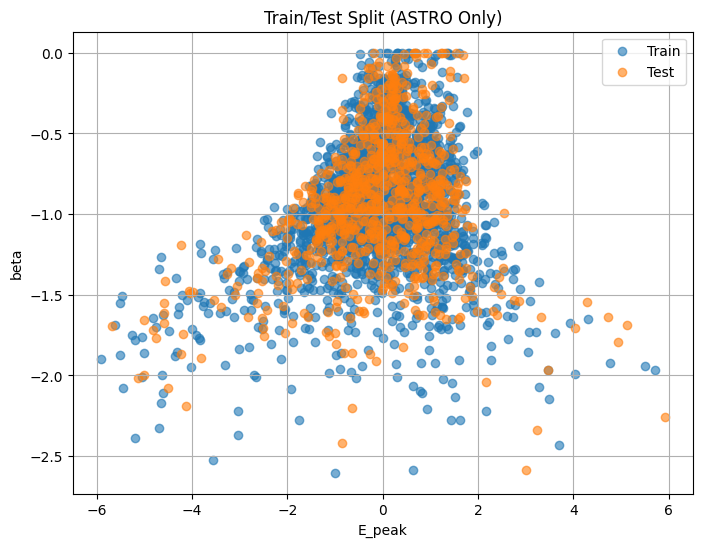

In [1119]:

# Quick Scatter Plot to double-check the distribution after splitting:
plt.figure(figsize=(8, 6))
plt.scatter(X_train[:, 1], X_train[:, 0], label='Train', alpha=0.6)
plt.scatter(X_test[:, 1], X_test[:, 0], label='Test', alpha=0.6)
plt.xlabel("E_peak")
plt.ylabel("beta")
plt.title("Train/Test Split (ASTRO Only)")
plt.legend()
plt.grid(True)
plt.show()

# 🎯 OneClassSVM Model - training

In [1120]:
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

X_test_scaled = scaler.transform(X_test)

# Initialize the model
clf = OneClassSVM(kernel='rbf', nu=0.05, gamma='scale')
# train the model
clf.fit(X_train_scaled)


OneClassSVM(nu=0.05)

# Visualize "learned" frontier of the trained model

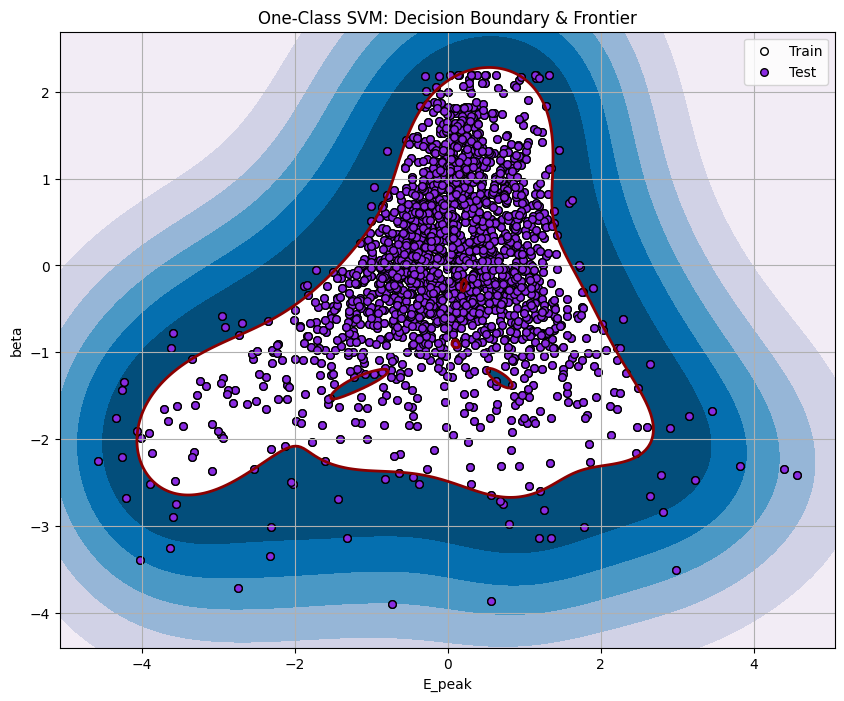

In [1121]:
import numpy as np
import matplotlib.pyplot as plt

# Create a meshgrid over the feature space
xx, yy = np.meshgrid(
    np.linspace(X_train_scaled[:, 1].min() - 0.5, X_train_scaled[:, 1].max() + 0.5, 300),  # E_peak
    np.linspace(X_train_scaled[:, 0].min() - 0.5, X_train_scaled[:, 0].max() + 0.5, 300)   # beta
)

# Stack into grid shape for prediction
grid = np.c_[yy.ravel(), xx.ravel()]  # Notice: beta first, then E_peak to match feature order
Z = clf.decision_function(grid)  # Get decision function values
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10, 8))

# Filled contour of decision function (the 'heatmap')
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap=plt.cm.PuBu)
plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='darkred')  # The learned frontier

# Plot training and test data
plt.scatter(X_train_scaled[:, 1], X_train_scaled[:, 0], c='white', edgecolors='k', s=30, label="Train")
plt.scatter(X_train_scaled[:, 1], X_train_scaled[:, 0], c='blueviolet', edgecolors='k', s=30, label="Test")

plt.xlabel("E_peak")
plt.ylabel("beta")
plt.title("One-Class SVM: Decision Boundary & Frontier")
plt.legend()
plt.grid(True)
plt.show()

# Make Predictions - ASTRO Test Set

In [1122]:
# make predictions
# +1 = inlier, -1 = outlier
y_pred_train = clf.predict(X_train_scaled)
y_pred_test = clf.predict(X_test_scaled)


In [ ]:
# Evaluate results of trained model
n_error_train = (y_pred_train == -1).sum()
n_error_test = (y_pred_test == -1).sum()

pct_error_train = 100 * n_error_train / len(X_train)
pct_error_test = 100 * n_error_test / len(X_test)

print(f"Training errors (outliers): {n_error_train}/{len(X_train_scaled)}")
print(f"Testing errors (outliers): {n_error_test}/{len(X_test_scaled)}")

Training errors (outliers): 98/1981
Testing errors (outliers): 36/850


## Visualize Prediction Results - ASTRO Test Set

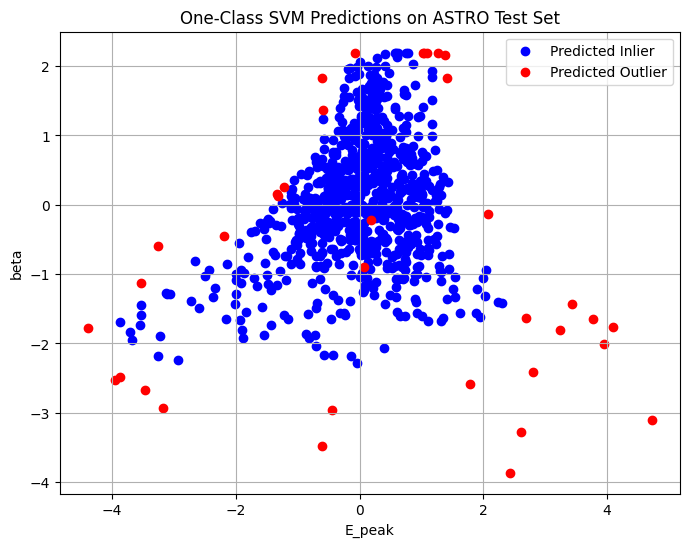

In [1124]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

# Plot normal predictions
plt.scatter(X_test_scaled[y_pred_test == 1, 1], X_test_scaled[y_pred_test == 1, 0], c="blue", label="Predicted Inlier")

# Plot predicted outliers
plt.scatter(X_test_scaled[y_pred_test == -1, 1], X_test_scaled[y_pred_test == -1, 0], c="red", label="Predicted Outlier")

plt.xlabel("E_peak")
plt.ylabel("beta")
plt.title("One-Class SVM Predictions on ASTRO Test Set")
plt.legend()
plt.grid(True)
plt.show()

Decision Function / Scoring

In [1125]:
scores = clf.decision_function(X_test_scaled)  # Higher = more normal

## Visualize UNIDs

In [1126]:
# Load the full dataset
unids_path = "../data/raw/unids_3F_beta_err_names.txt"
df_unids = pd.read_csv(unids_path, sep='\s+')

df_unids.head()

,E_peak,beta,sigma_det,beta_Rel,number
0,2.51290,0.0897,7.3996,1.630992,0
1,1.47820,0.4163,5.4150,0.770838,1
2,1.59640,0.6783,10.7909,0.371222,2
3,0.93095,0.2771,7.6056,0.628654,3
4,0.44480,0.3207,4.2748,0.567509,4


In [1127]:
# Apply log10 to selected columns
cols_to_log = ["E_peak", "beta", "sigma_det", "beta_Rel"]
df_unids_log = df_unids.copy()
df_unids_log[cols_to_log] = df_unids_log[cols_to_log].apply(lambda x: np.log10(x.clip(lower=1e-10)))

df_unids_log.head()

,E_peak,beta,sigma_det,beta_Rel,number
0,0.400175,-1.047208,0.869208,0.212452,0
1,0.169733,-0.380594,0.733598,-0.113037,1
2,0.203142,-0.168578,1.033058,-0.430366,2
3,-0.031074,-0.557363,0.881133,-0.201588,3
4,-0.351835,-0.493901,0.630916,-0.246028,4


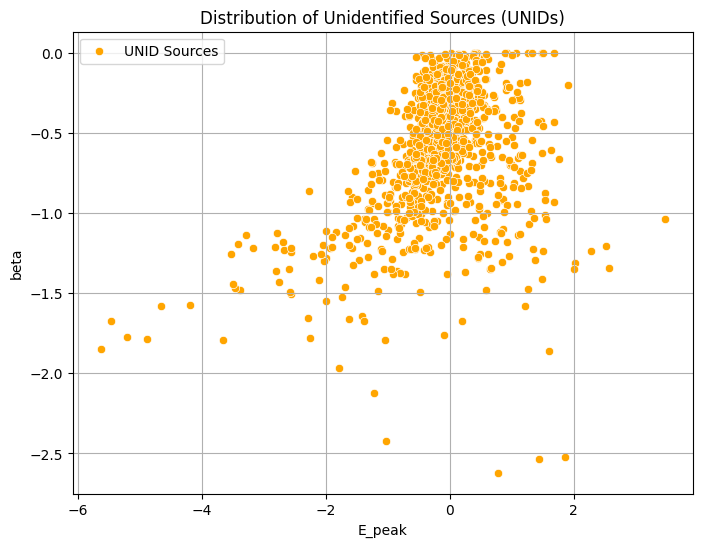

In [1128]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_unids_log, x="E_peak", y="beta", color="orange", label="UNID Sources")
plt.title("Distribution of Unidentified Sources (UNIDs)")
plt.xlabel("E_peak")
plt.ylabel("beta")
plt.grid(True)
plt.legend()
plt.show()

## Visualize ASTRO + UNIDs Data

In [1129]:
# Extract features for prediction (same as model input order)
X_unids_log = df_unids_log[["beta", "E_peak"]].values

# Scale using the fitted scaler (from training on ASTRO data)
X_unids_scaled = scaler.transform(X_unids_log)

# What we feed to the model
X_outliers = X_unids_scaled

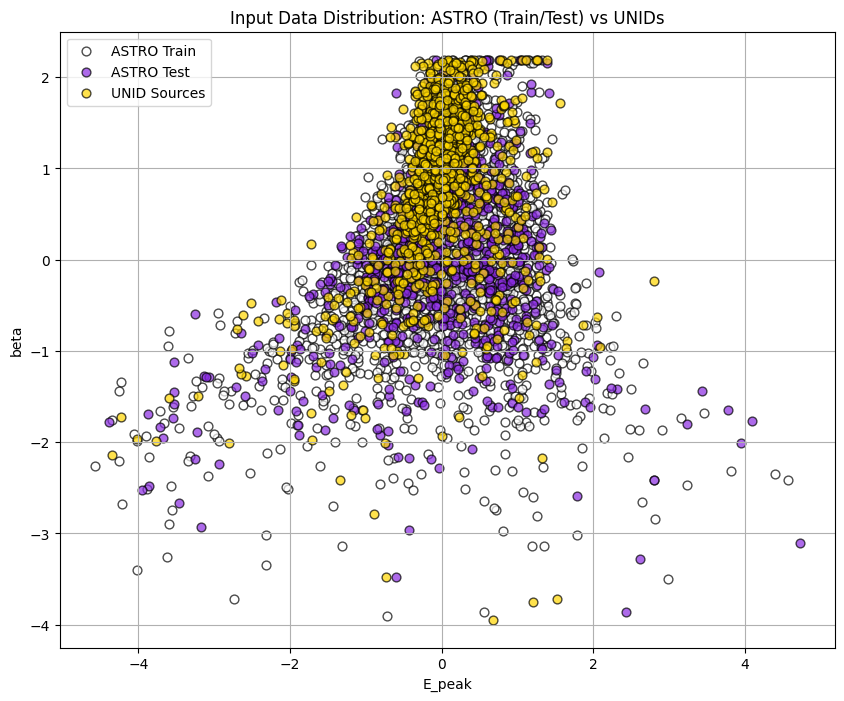

In [1130]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))

# Plot ASTRO training data
plt.scatter(X_train_scaled[:, 1], X_train_scaled[:, 0], c='white', edgecolors='k', label='ASTRO Train', alpha=0.7, s=40)

# Plot ASTRO test data
plt.scatter(X_test_scaled[:, 1], X_test_scaled[:, 0], c='blueviolet', edgecolors='k', label='ASTRO Test', alpha=0.7, s=40)

# Plot UNID data (can be log10-transformed if you're using that version)
plt.scatter(X_outliers[:, 1], X_outliers[:, 0], c='gold', edgecolors='k', label='UNID Sources', alpha=0.7, s=40)

# Labels and legend
plt.xlabel("E_peak")
plt.ylabel("beta")
plt.title("Input Data Distribution: ASTRO (Train/Test) vs UNIDs")
plt.grid(True)
plt.legend(loc='upper left')
plt.show()

# Make Predictions - UNIDs

In [ ]:
# Predict
y_pred_unids = clf.predict(X_outliers)
n_predicted_inliers = (y_pred_unids == 1).sum()
n_predicted_outliers = (y_pred_unids == -1).sum()

# Errors
n_error_outliers = (y_pred_outliers == 1).sum()
pct_outliers = 100 * n_error_outliers / len(X_outliers)


print(f"Predicted as inliers: {n_predicted_inliers}")
print(f"Predicted as outliers (novel): {n_predicted_outliers}")

Predicted as inliers: 1077
Predicted as outliers (novel): 48


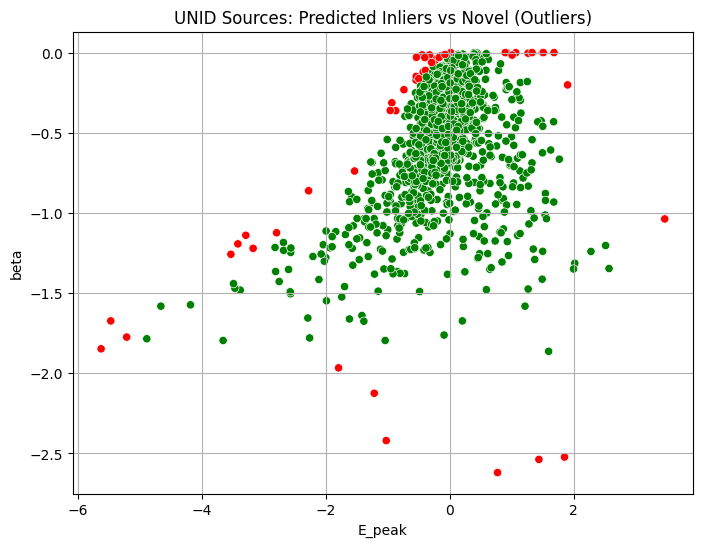

In [1132]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=X_unids_log[:, 1],  # E_peak
    y=X_unids_log[:, 0],  # beta
    hue=(y_pred_unids_log == -1),
    palette={True: "red", False: "green"},
    legend=False
)
plt.xlabel("E_peak")
plt.ylabel("beta")
plt.title("UNID Sources: Predicted Inliers vs Novel (Outliers)")
plt.grid(True)
plt.show()

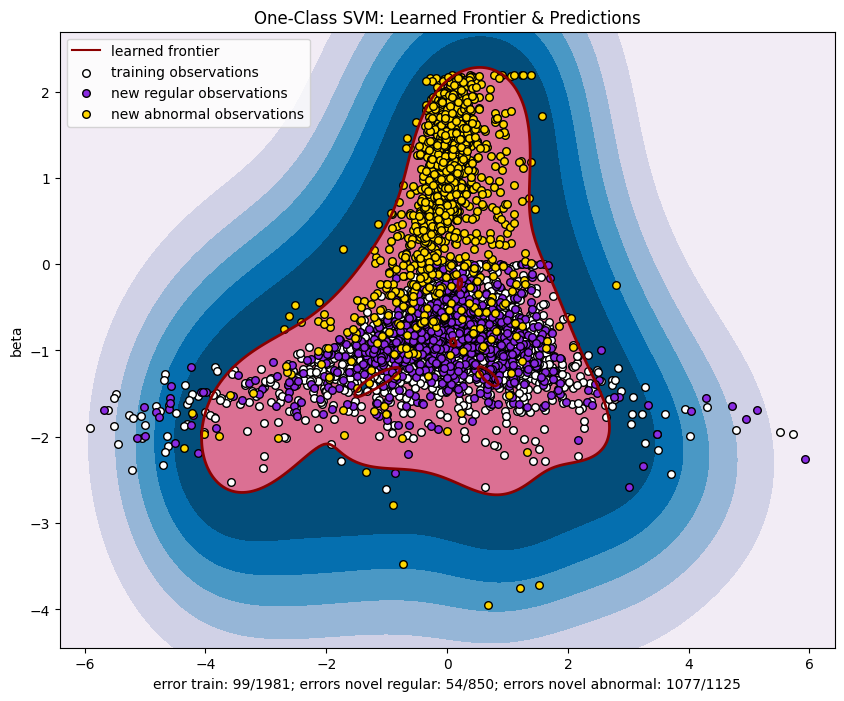

In [1133]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import numpy as np
from sklearn.inspection import DecisionBoundaryDisplay

# Define the plotting grid range based on your data
x_min = min(X_train[:, 1].min(), X_test[:, 1].min(), X_outliers[:, 1].min()) - 0.5  # E_peak
x_max = max(X_train[:, 1].max(), X_test[:, 1].max(), X_outliers[:, 1].max()) + 0.5
y_min = min(X_train[:, 0].min(), X_test[:, 0].min(), X_outliers[:, 0].min()) - 0.5  # beta
y_max = max(X_train[:, 0].max(), X_test[:, 0].max(), X_outliers[:, 0].max()) + 0.5

# Create meshgrid
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300), np.linspace(y_min, y_max, 300))
grid = np.c_[yy.ravel(), xx.ravel()]  # beta (y), E_peak (x)

# Compute decision function
Z = clf.decision_function(grid).reshape(xx.shape)

# Plot
fig, ax = plt.subplots(figsize=(10, 8))

# Filled contour (decision score map)
contour1 = ax.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap="PuBu")
contour2 = ax.contour(xx, yy, Z, levels=[0], colors="darkred", linewidths=2)
contour3 = ax.contourf(xx, yy, Z, levels=[0, Z.max()], colors="palevioletred")

# Plot training, regular test, and novel outlier data
s = 30
b1 = ax.scatter(X_train[:, 1], X_train[:, 0], c="white", s=s, edgecolors="k")  # Train (E_peak, beta)
b2 = ax.scatter(X_test[:, 1], X_test[:, 0], c="blueviolet", s=s, edgecolors="k")  # Test
c = ax.scatter(X_outliers[:, 1], X_outliers[:, 0], c="gold", s=s, edgecolors="k")  # Outliers

# Predictions and error counts
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
y_pred_outliers = clf.predict(X_outliers)
n_error_train = (y_pred_train == -1).sum()
n_error_test = (y_pred_test == -1).sum()
n_error_outliers = (y_pred_outliers == 1).sum()

# Axis & legend
ax.set(
    title="One-Class SVM: Learned Frontier & Predictions",
    xlim=(xx.min(), xx.max()),
    ylim=(yy.min(), yy.max()),
    xlabel=(
        f"error train: {n_error_train}/{len(X_train)}; "
        f"errors novel regular: {n_error_test}/{len(X_test)}; "
        f"errors novel abnormal: {n_error_outliers}/{len(X_outliers)}"
    ),
    ylabel="beta"
)

# Custom legend
_ = ax.legend(
    [
        mlines.Line2D([], [], color="darkred", label="learned frontier"),
        b1, b2, c
    ],
    [
        "learned frontier",
        "training observations",
        "new regular observations",
        "new abnormal observations"
    ],
    loc="upper left"
)

## Logs with Model Parameters, Data & Performmance

In [1134]:
import datetime

# Log file path (relative to notebook)
log_path = "../logs/ocsvm_results.log"

# Create logs directory if it doesn't exist
import os
os.makedirs(os.path.dirname(log_path), exist_ok=True)

# Get current timestamp
timestamp = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")

# Build log string
log_lines = [
    f"========== One-Class SVM Log ({timestamp}) ==========\n",
    f"Model parameters:",
    f"    Kernel      : {clf.kernel}",
    f"    Nu          : {clf.nu}",
    f"    Gamma       : {clf.gamma}",
    "",
    f"Training data:",
    f"    Source      : ASTRO (normalized/log10)",
    f"    Samples     : {len(X_train)}",
    f"    Train errors: {n_error_train}/{len(X_train)} ({pct_error_train:.2f}%)",
    "",
    f"Testing data (ASTRO):",
    f"    Samples     : {len(X_test)}",
    f"    Test errors : {n_error_test}/{len(X_test)} ({pct_error_test:.2f}%)",
    "",
    f"UNID Outlier Detection:",
    f"    Samples     : {len(X_outliers)}",
    f"    Predicted Inliers (missed outliers): {n_error_outliers}/{len(X_outliers)}",
    f"    Predicted Outliers                 : {n_error_outliers}/{len(X_outliers)} ({pct_outliers:.2f}%)",
    "",
    "======================================================\n"
]

# Write to log file (append mode)
with open(log_path, "a") as f:
    f.write("\n".join(log_lines))

NameError: name 'pct_error_train' is not defined

# Color-Coded Scatter Plot by Model Prediction

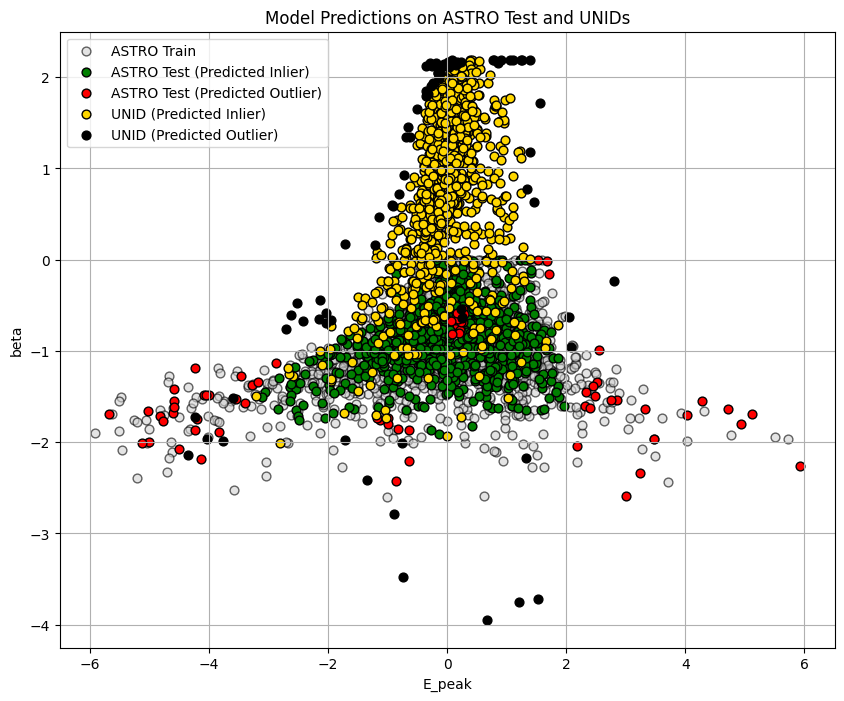

In [ ]:
import matplotlib.pyplot as plt

# Predict for test and outlier data
y_pred_test = clf.predict(X_test)          # ASTRO test data
y_pred_unids = clf.predict(X_outliers)     # UNIDs

# Plot
plt.figure(figsize=(10, 8))

# ASTRO Training Data (assumed all inliers, so neutral color)
plt.scatter(X_train[:, 1], X_train[:, 0], c='lightgray', edgecolors='k', label='ASTRO Train', alpha=0.6, s=40)

# ASTRO Test Data - green = predicted inlier, red = predicted outlier
plt.scatter(X_test[y_pred_test == 1][:, 1], X_test[y_pred_test == 1][:, 0],
            c='green', edgecolors='k', label='ASTRO Test (Predicted Inlier)', s=40)
plt.scatter(X_test[y_pred_test == -1][:, 1], X_test[y_pred_test == -1][:, 0],
            c='red', edgecolors='k', label='ASTRO Test (Predicted Outlier)', s=40)

# UNID Data - green = predicted inlier, red = predicted novel
plt.scatter(X_outliers[y_pred_unids == 1][:, 1], X_outliers[y_pred_unids == 1][:, 0],
            c='gold', edgecolors='k', label='UNID (Predicted Inlier)', s=40)
plt.scatter(X_outliers[y_pred_unids == -1][:, 1], X_outliers[y_pred_unids == -1][:, 0],
            c='black', edgecolors='k', label='UNID (Predicted Outlier)', s=40)

# Labels
plt.xlabel("E_peak")
plt.ylabel("beta")
plt.title("Model Predictions on ASTRO Test and UNIDs")
plt.legend(loc="upper left")
plt.grid(True)
plt.show()